<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="200">

# Leaf Segmentation with Detectron2

Trains a Mask-RCNN model on Superfund leaf dataset.



# Setup

### Install requirements

First we install our python requirements. These requirements assume that detectron2 has already been installed on the system.  We are running our notebooks within a [gpu-jupyter](https://hub.docker.com/r/cschranz/gpu-jupyter) docker container that has been modified to additionally include detectron2.

In [3]:
# requirements
!pip install pyyaml==5.1
!pip install opencv-python
!pip install matplotlib

# cocosplit requirements
!pip install sklearn funcy argparse scikit-multilearn

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


### Split dataset into test/validation sets

Next, we split our annotations, which are in COCO format, into training and validation sets.  We borrowed a script from [akarazniewicz/cocosplit](https://github.com/akarazniewicz/cocosplit).

In [5]:
today = "12-5"
output_folder = "output_" + today

# run cocosplit script to split annotations into training and validation sets

run = f"python ./cocosplit.py\
         --having-annotations\
         -s 0.8\
         data/leaves-coco-verified.json\
         %s/leaves_train.json\
         %s/leaves_val.json" % (output_folder, output_folder)

!{run}

Saved 1076 entries in output_12-5/leaves_train.json and 303 in output_12-5/leaves_val.json


### Imports



In [6]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

torch:  1.12 ; cuda:  cu116


# Train on leaf dataset

In this section, we train a leaf segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

## Prepare the dataset

Register the leaf dataset to detectron2.  Since the dataset is already in COCO format, we can use detectron2's built-in method `register_coco_instances`.


In [7]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("train_" + today, {}, "/home/jovyan/work/%s/leaves_train.json" % output_folder, "/home/jovyan/work/data/")
register_coco_instances("val_" + today, {}, "/home/jovyan/work/%s/leaves_val.json" % output_folder, "/home/jovyan/work/data/")


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



WARNING [12/05 18:00:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/05 18:00:54 d2.data.datasets.coco]: Loaded 155 images in COCO format from /home/jovyan/work/output_12-5/leaves_train.json


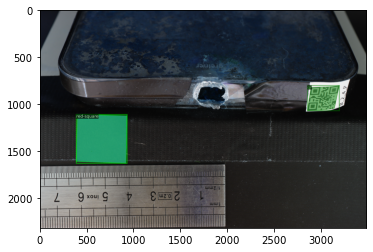

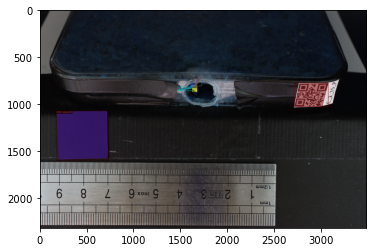

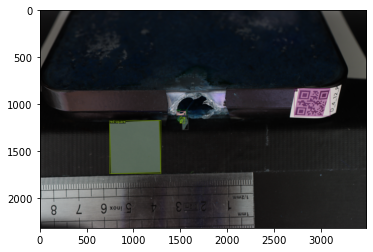

In [8]:
leaf_metadata = MetadataCatalog.get("train_" + today)
dataset_dicts = DatasetCatalog.get("train_" + today)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=leaf_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the leaf dataset.

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_" + today,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # leaf dataset has 3 classes (leaf, qr, red-square)

cfg.OUTPUT_DIR = './%s' % output_folder
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/05 18:01:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[12/05 18:01:17 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/05 18:01:43 d2.utils.events]:  eta: 1:43:02  iter: 19  total_loss: 3.616  loss_cls: 1.551  loss_box_reg: 0.2402  loss_mask: 0.6942  loss_rpn_cls: 1.056  loss_rpn_loc: 0.1285  time: 1.2557  data_time: 1.0338  lr: 4.9953e-06  max_mem: 2284M
[12/05 18:02:08 d2.utils.events]:  eta: 1:42:50  iter: 39  total_loss: 3.22  loss_cls: 1.408  loss_box_reg: 0.2553  loss_mask: 0.69  loss_rpn_cls: 0.7241  loss_rpn_loc: 0.1346  time: 1.2573  data_time: 1.0410  lr: 9.9902e-06  max_mem: 2409M
[12/05 18:02:34 d2.utils.events]:  eta: 1:43:25  iter: 59  total_loss: 2.83  loss_cls: 1.134  loss_box_reg: 0.2924  loss_mask: 0.6817  loss_rpn_cls: 0.4853  loss_rpn_loc: 0.1321  time: 1.2656  data_time: 1.0850  lr: 1.4985e-05  max_mem: 2409M
[12/05 18:02:59 d2.utils.events]:  eta: 1:43:35  iter: 79  total_loss: 2.43  loss_cls: 0.9005  loss_box_reg: 0.3453  loss_mask: 0.6736  loss_rpn_cls: 0.3446  loss_rpn_loc: 0.1438  time: 1.2649  data_time: 1.0648  lr: 1.998e-05  max_mem: 2409M
[12/05 18:03:25 d2.utils.event

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("val_" + today)
leaf_metadata = MetadataCatalog.get("val_" + today)

for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=leaf_metadata, 
                   # scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()